# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
# Commented out this because of https://knowledge.udacity.com/questions/1047911
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# !rm -rf /root/tensorflow_datasets/self-service-06c1a653-nd-230-cd-0375-tensorflow-gpu-v-11:1.0

In [2]:
# Commented out this because of https://knowledge.udacity.com/questions/1047911
# %pip --no-cache-dir install tensorflow-datasets --user
# %pip --no-cache-dir install tfds-nightly --user
# %pip --no-cache-dir install --upgrade tensorflow --user

After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Import tensorflow related modules
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

/Users/menilik/Src/udacity/Udacity-Intro-To-ML-Nanodegree/neural_networks/image_classifier/virtualenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# TODO: Make all other necessary imports.
import matplotlib.pyplot as plt
import json
from workspace_utils import active_session

In [6]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

In [7]:
print(f'TF version: {tf.__version__}')
print(f'TFDS version: {tfds.__version__}')
print(f'TF Hub version: {hub.__version__}')

TF version: 2.12.0
TFDS version: 4.8.3+nightly
TF Hub version: 0.12.0


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [8]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load() -- DONE
splits = ['train', 'validation', 'test']

dataset, dataset_info = tfds.load('oxford_flowers102', split=splits, as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set. -- DONE
training_set, validation_set, test_set = dataset

2024-09-05 06:59:06.953182: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dataset oxford_flowers102 downloaded and prepared to /Users/menilik/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [9]:
len(training_set)

1020

In [10]:
len(validation_set)

1020

In [11]:
len(test_set)

6149

In [12]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

In [13]:
# TODO: Get the number of examples in each set from the dataset info. -- DONE
test_size = dataset_info.splits['test'].num_examples
train_size = dataset_info.splits['train'].num_examples
validation_size = dataset_info.splits['validation'].num_examples
print(f'The dataset contains {train_size} training, {validation_size} validation, and {test_size} testing images.')

# TODO: Get the number of classes in the dataset from the dataset info. -- DONE
print(f"There are {dataset_info.features['label'].num_classes} classes in the dataset.")

The dataset contains 1020 training, 1020 validation, and 6149 testing images.
There are 102 classes in the dataset.


In [14]:
# The official documentation doesn't have the labels stated; it requires downloading a .mat
# file and decoding it using Matlab, which I can't do.
# Hence, downloaded the labels from https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1.
# In the later section, Udacity provides the labels as a JSON files. It will be used after some point.
label_key = [
    'pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',
 'geranium',
 'orange dahlia',
 'pink-yellow dahlia',
 'cautleya spicata',
 'japanese anemone',
 'black-eyed susan',
 'silverbush',
 'californian poppy',
 'osteospermum',
 'spring crocus',
 'bearded iris',
 'windflower',
 'tree poppy',
 'gazania',
 'azalea',
 'water lily',
 'rose',
 'thorn apple',
 'morning glory',
 'passion flower',
 'lotus',
 'toad lily',
 'anthurium',
 'frangipani',
 'clematis',
 'hibiscus',
 'columbine',
 'desert-rose',
 'tree mallow',
 'magnolia',
 'cyclamen',
 'watercress',
 'canna lily',
 'hippeastrum',
 'bee balm',
 'ball moss',
 'foxglove',
 'bougainvillea',
 'camellia',
 'mallow',
 'mexican petunia',
 'bromelia',
 'blanket flower',
 'trumpet creeper',
 'blackberry lily',
]

# Make sure the number of labels matches the listed labels.
assert len(label_key) == dataset_info.features['label'].num_classes

In [15]:
# TODO: Print the shape and corresponding label of 3 images in the training set. --DONE
counter = 1
for image, label in training_set.take(3):
    image_shape = image.numpy().shape
    label = label
    print (f'Image {counter}: shape = {image_shape}, label = {label_key[label]}')
    counter += 1

Image 1: shape = (500, 667, 3), label = water lily
Image 2: shape = (500, 666, 3), label = desert-rose
Image 3: shape = (670, 500, 3), label = gazania


2024-09-05 07:07:44.295388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-09-05 07:07:44.295759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-09-05 07:07:44.310817: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2024-09-05 07:07:45.300401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-09-05 07:07:45.300819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


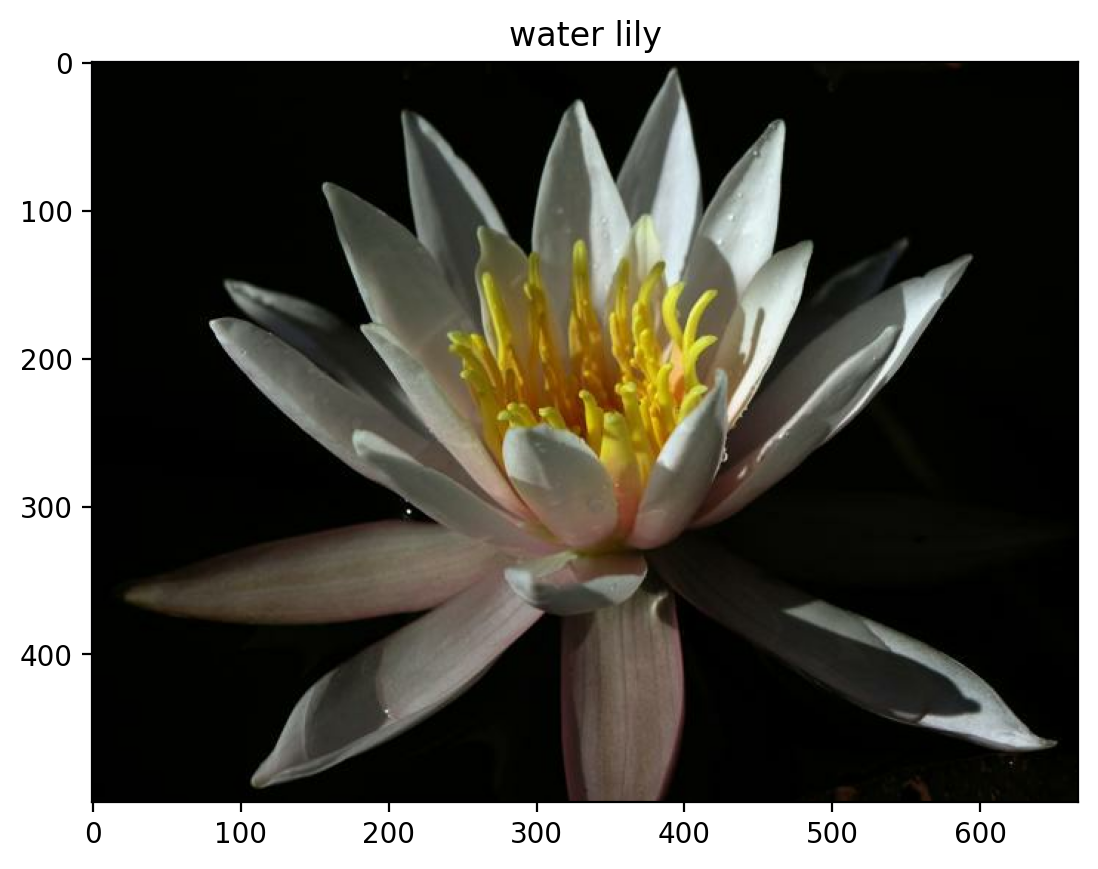

In [16]:
# TODO: Plot 1 image from the training set. -- DONE
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

# Plot the image
plt.imshow(image)
# Set the title of the plot to the corresponding image label. 
plt.title(label_key[label])
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [17]:
# From now on, the label from Udacity will be used.
with open('label_map.json', 'r') as f:
    class_names = json.load(f)
    
# assert the class names is within the same size of the expected numbers (102)
assert len(class_names) == dataset_info.features['label'].num_classes

2024-09-05 07:07:54.261462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-09-05 07:07:54.262163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


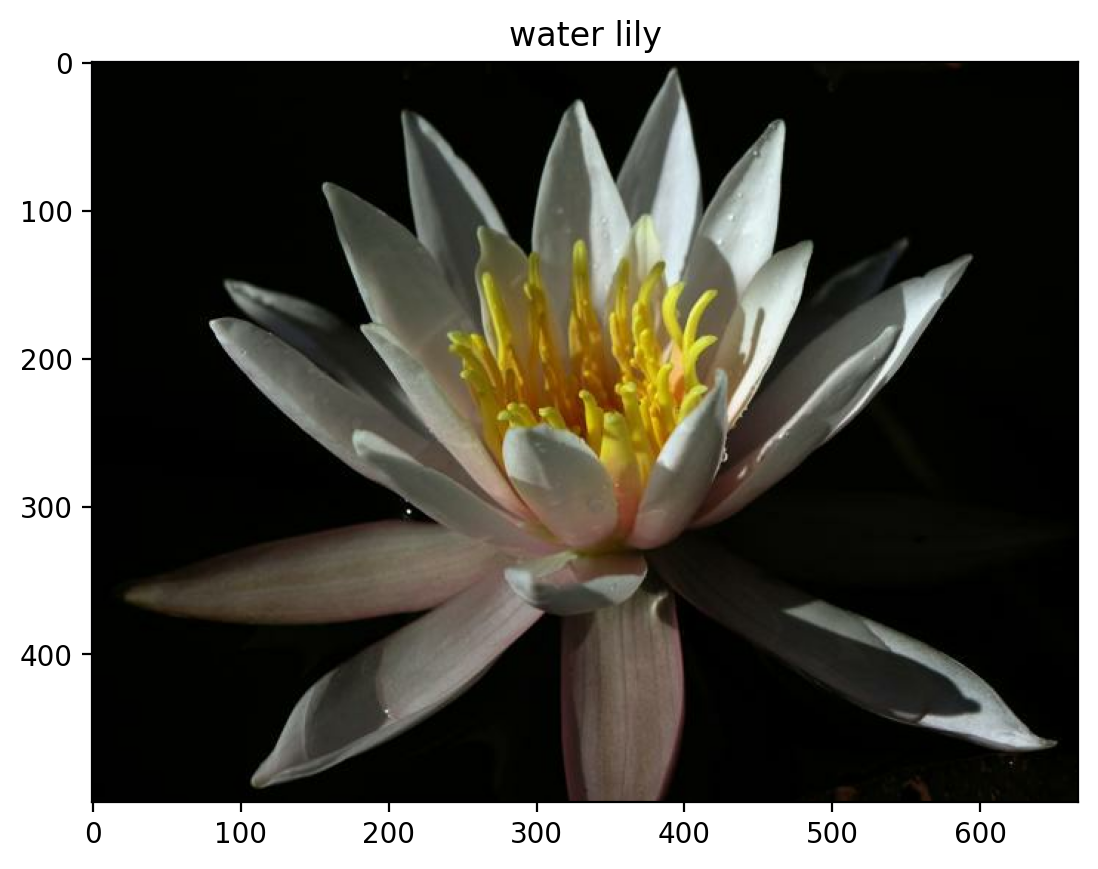

In [18]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. -- DONE
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

# Plot the image
plt.imshow(image)
# Set the title of the plot to the corresponding image label. 
plt.title(class_names.get(f'{label+1}'))
plt.show()

## Create Pipeline

In [19]:
# TODO: Create a pipeline for each set. -- DONE
image_size = 224 # What the MobileNet expects 

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

batch_size = 34

# NOTICE: Here the ordering of map and batch operations matter. Since the image shapes are not the same
# [look at the cell above where we printed training images above], the map operation needs to come first
# to reshape them into the same image_size x image_size images. Then batching can be done.
# If batching comes before map, it won't fail here. However, training or even iterating through the batches
# and printing will not be possible!
training_batches = training_set.cache().shuffle(train_size//4).map(normalize).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(normalize).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(normalize).batch(batch_size).prefetch(1)

Going to see if the batching worked above by doing a simple iteration over the batches. If the following cell fails with error `InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [500,571,3] and element 40 had shape [500,500,3]` (for training batch for example), it's because of the ordering of the transformations or the function inside map. Make sure they are equi-shape before batching! 

In [20]:
for image, label in training_batches.take(1):
    print (f'Training shape: {image.shape}')
    
for image, label in testing_batches.take(1):
    print (f'Testing shape: {image.shape}')
    
for image, label in validation_batches.take(1):
    print (f'Validation shape: {image.shape}')

2024-09-05 07:08:08.704819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-09-05 07:08:08.705529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-09-05 07:08:08.825475: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

Training shape: (34, 224, 224, 3)
Testing shape: (34, 224, 224, 3)
Validation shape: (34, 224, 224, 3)


2024-09-05 07:08:08.907437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Confirmed! The images are of batch 34, 224 by 224, and RGB (3). 

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [21]:
# Import the pre-trained model to extract feature.
# The 224 in the URL below is the input shape that's expected from the model. If you change that value, update
# the input_shape as well!
# https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
# https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-classification/2
feature_extractor = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
               trainable=False, input_shape=(image_size, image_size, 3))

In [22]:
# TODO: Build your network. -- DONE
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(len(class_names), activation = 'softmax')
])

Let's see the model built. It should have the output shape of 102, the same as the number of flowers we are classifying.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
# TODO: Prepare the model's loss and metrics. -- DONE
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Let's see the pre-training loss and accuracy. 

In [25]:
# Pre-training, let's see the loss and accuracy.
# loss, accuracy = model.evaluate(testing_batches)

# print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
# print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

In [26]:
EPOCHS = 5

training_history = model.fit(training_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/5


2024-09-05 07:08:47.246368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-05 07:08:47.246987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-09-05 07:08:47.664363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like/StatefulPartitionedCall' with dtype

30/30 [==============================] - ETA: 0s - loss: 4.2026 - accuracy: 0.1373

2024-09-05 07:08:51.600978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-09-05 07:08:51.601161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


30/30 [==============================] - 8s 235ms/step - loss: 4.2026 - accuracy: 0.1373 - val_loss: 3.0781 - val_accuracy: 0.3765
Epoch 2/5
30/30 [==============================] - 7s 221ms/step - loss: 2.0723 - accuracy: 0.6931 - val_loss: 1.9919 - val_accuracy: 0.6647
Epoch 3/5
30/30 [==============================] - 6s 212ms/step - loss: 1.1163 - accuracy: 0.9098 - val_loss: 1.5231 - val_accuracy: 0.7294
Epoch 4/5
30/30 [==============================] - 6s 218ms/step - loss: 0.6822 - accuracy: 0.9608 - val_loss: 1.2846 - val_accuracy: 0.7647
Epoch 5/5
30/30 [==============================] - 7s 220ms/step - loss: 0.4579 - accuracy: 0.9814 - val_loss: 1.1499 - val_accuracy: 0.7990


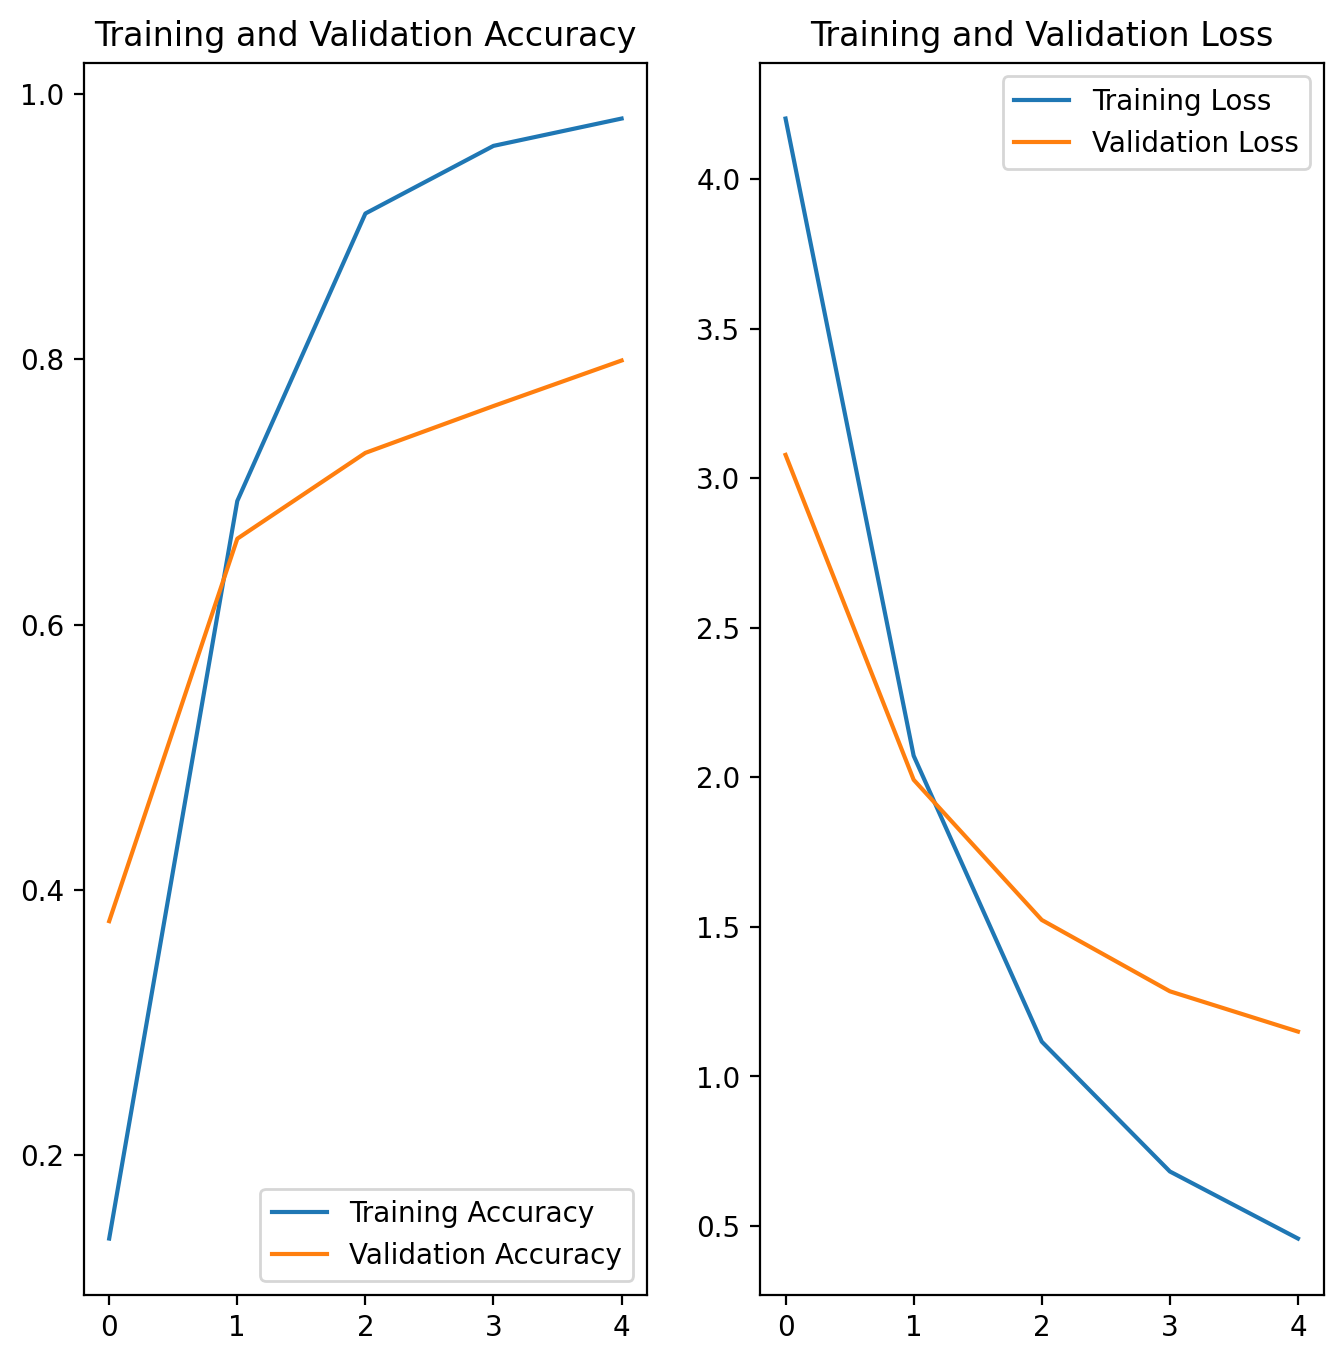

In [27]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set. -- DONE
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

training_loss = training_history.history['loss']
validation_loss = training_history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [28]:
# TODO: Print the loss and accuracy values achieved on the entire test set. --DONE
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

  1/181 [..............................] - ETA: 30s - loss: 1.2656 - accuracy: 0.8529

2024-09-05 07:09:27.858617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2024-09-05 07:09:27.859271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]


  2/181 [..............................] - ETA: 13s - loss: 1.3314 - accuracy: 0.7857WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 181 batches). You may need to use the repeat() function when building your dataset.


181/181 [==============================] - 0s 1ms/step - loss: 1.3314 - accuracy: 0.7857

Loss on the TEST Set: 1.331
Accuracy on the TEST Set: 78.571%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [29]:
# TODO: Save your trained model as a Keras model.
import time

saved_model_path = './{}.h5'.format(int(time.time()))
model.save(saved_model_path)

print(f'Model {saved_model_path} saved!')

Model ./1725545374.h5 saved!


## Load the Keras Model

Load the Keras model you saved above.

In [30]:
# TODO: Load the Keras model
loaded_keras_model = tf.keras.models.load_model(saved_model_path, custom_objects={'KerasLayer':hub.KerasLayer}) # tf.keras.models.load_model(saved_model_path)

loaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [31]:
# TODO: Create the process_image function -- DONE
def process_image (image):
    """
    Processes the given image by converting to Tensor,
    normalizing the values to be between [0 and 1],
    and resizing the image to ({image_size} x {image_size}).
    """
    image = tf.convert_to_tensor(image / 255, dtype=tf.float32)
    return tf.image.resize(image, (image_size, image_size))

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

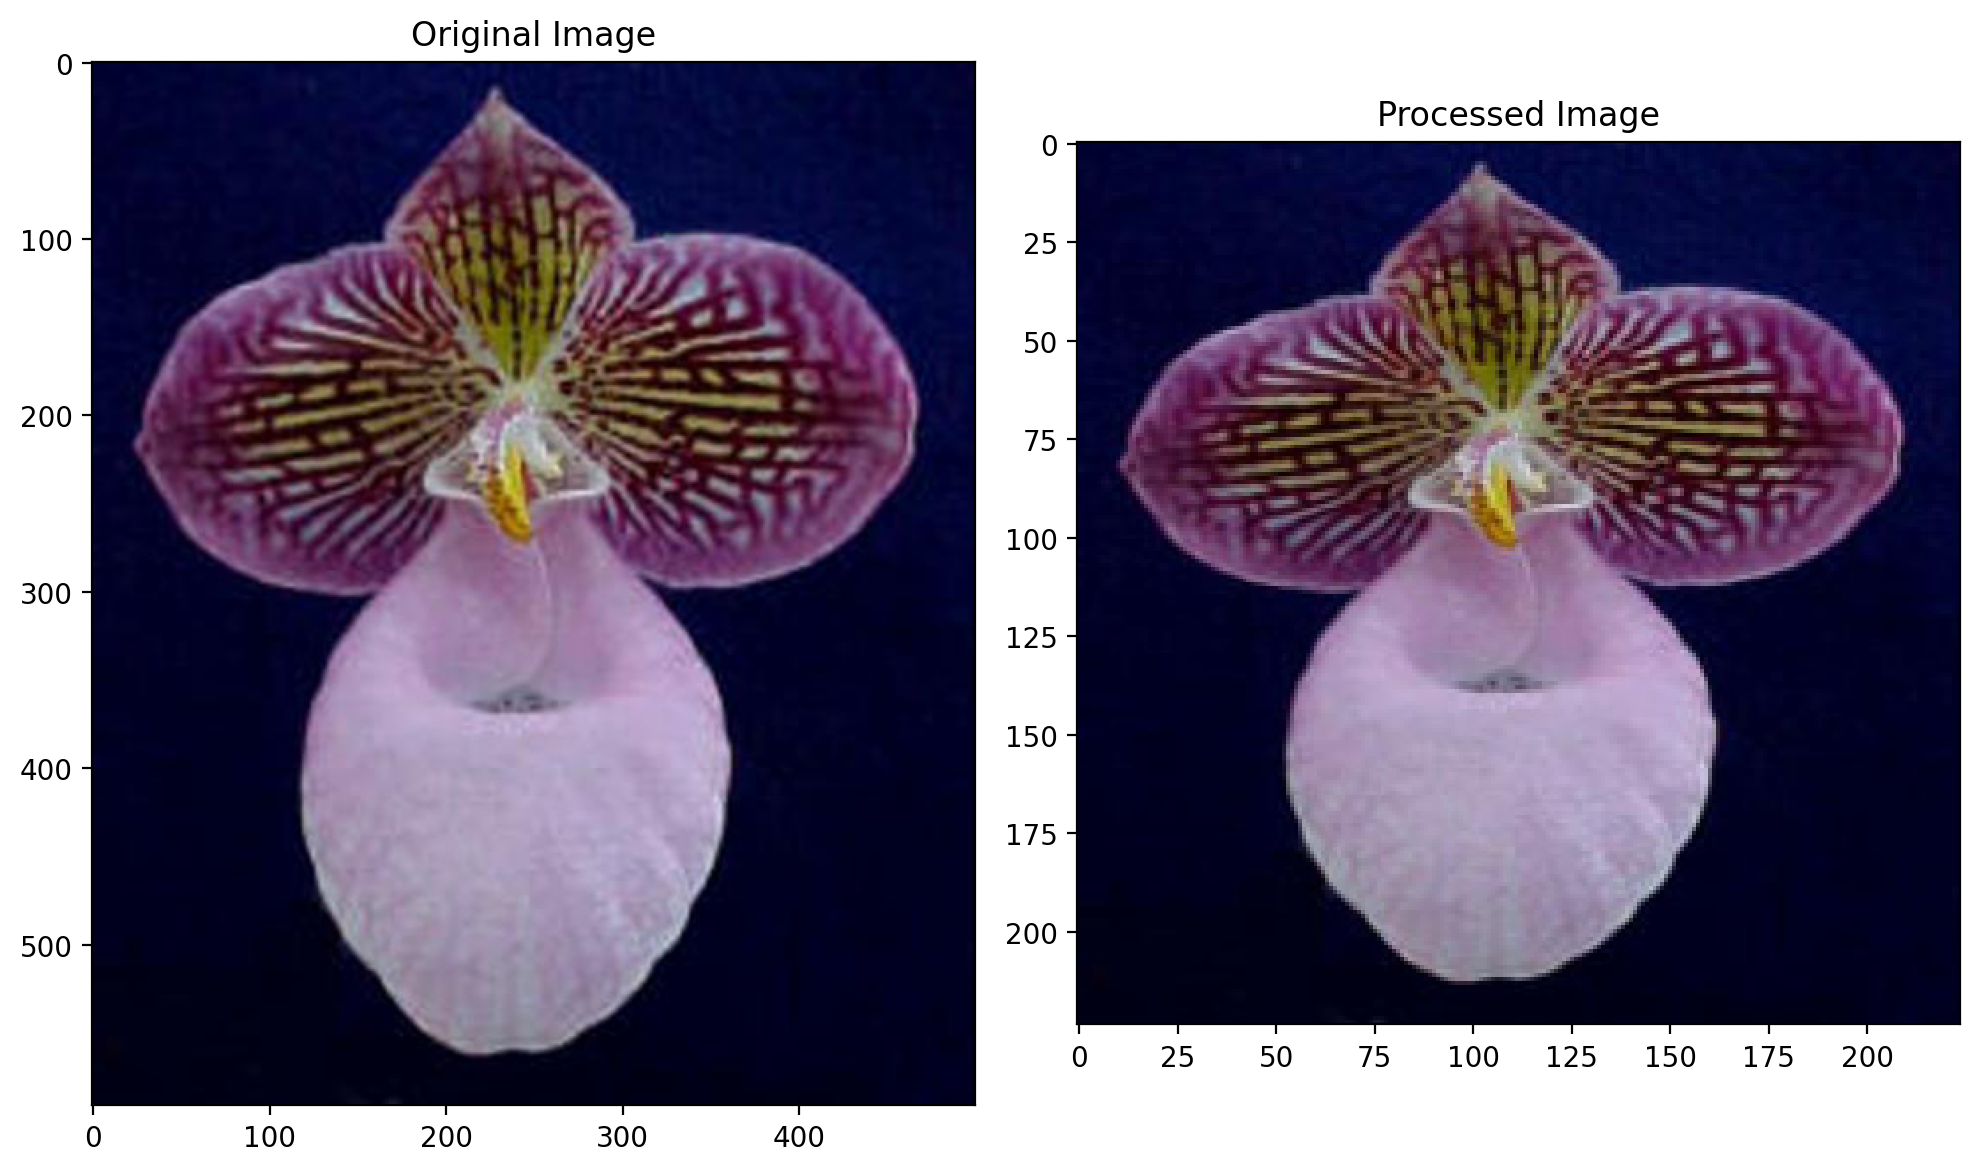

In [32]:
from PIL import Image
import numpy as np

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [33]:
# TODO: Create the predict function
def predict (image, model, top_k):
    """
    Predicts and returns the top K probable labels for the given image
    by predicting using the given model. The image needs to be of size
    (224, 224, 3).
    """
    
    def list_to_dict (l):
        dic = {}
        for index, val in enumerate (l):
            dic[index] = val
        return dic

    # Convert from (224, 224, 3) to (1, 224, 224, 3)
    image = tf.expand_dims(image, axis=0)
    predictions = model.predict(image)
    label_to_prob = list_to_dict(predictions[0])
    # Capture the keys (labels) by sorting based on the values (probabilities)
    top_labels = sorted(label_to_prob, key=label_to_prob.get, reverse=True)[:top_k]
    return [label_to_prob[label] for label in top_labels], top_labels

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 157ms/step


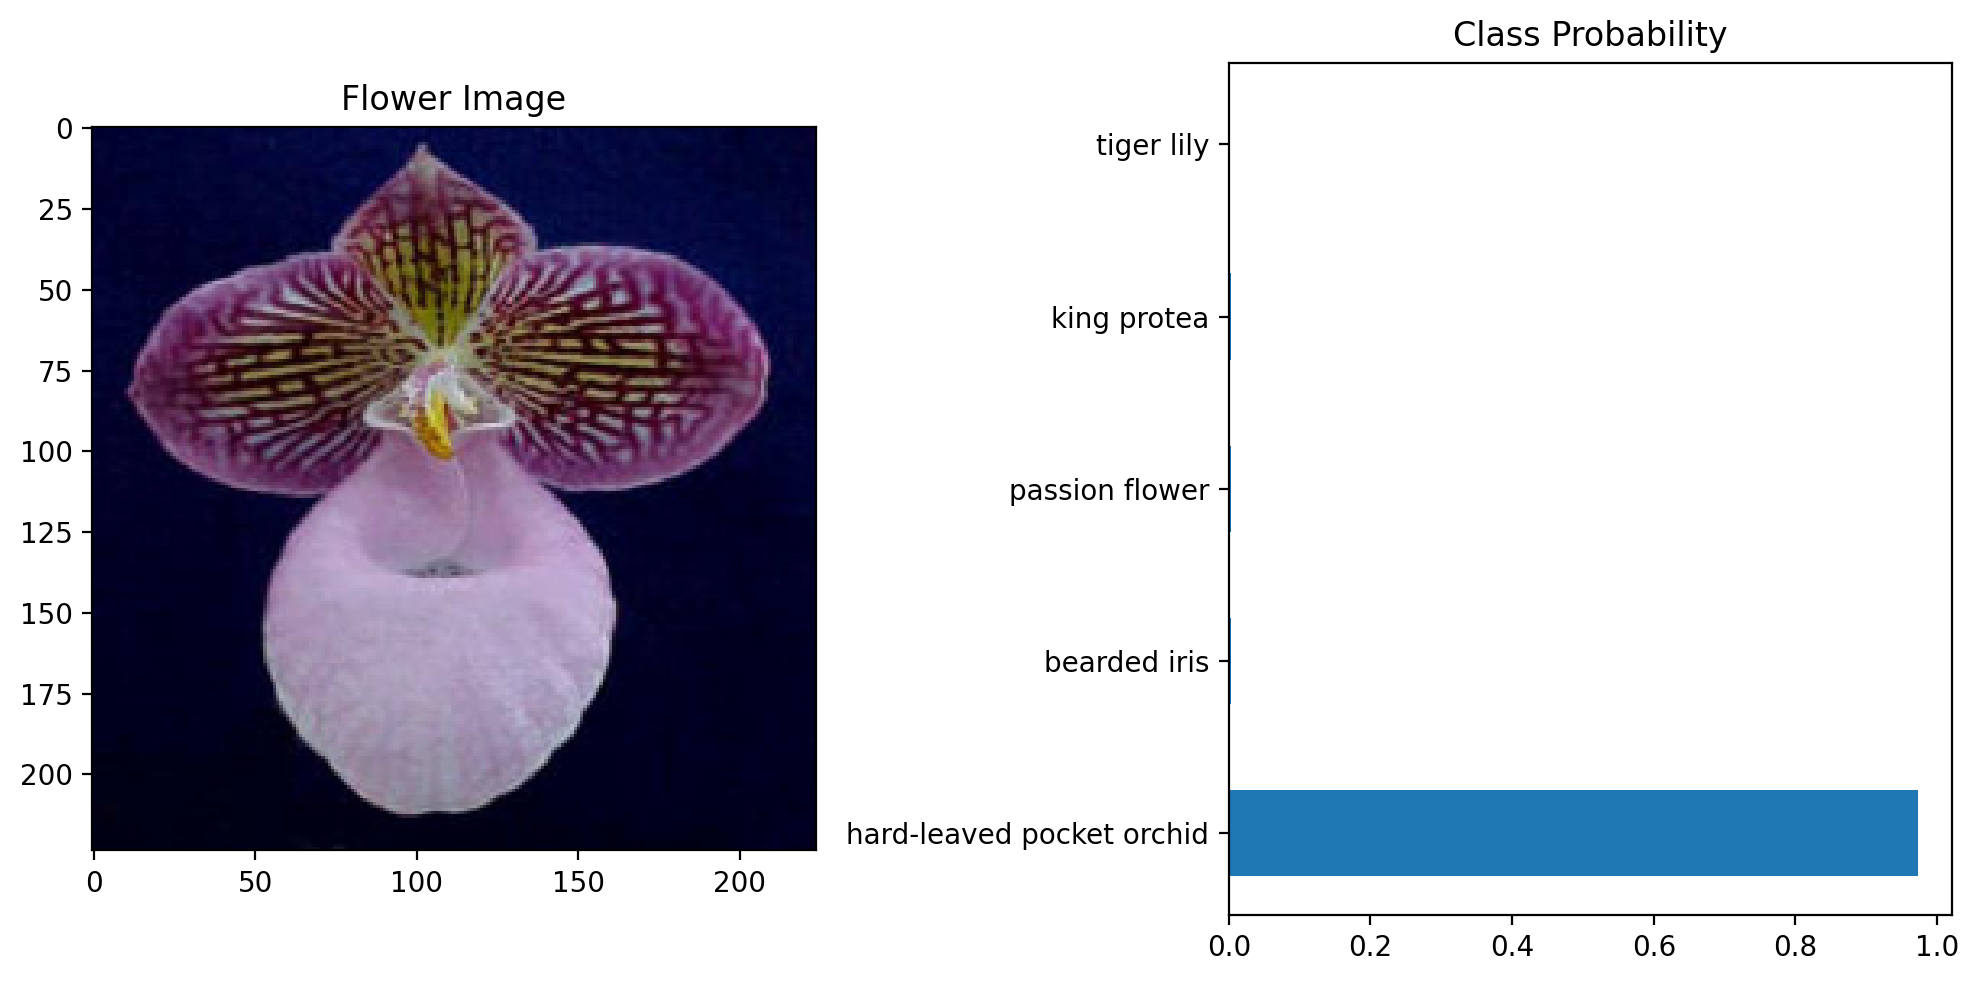

1/1 [==============================] - 0s 15ms/step


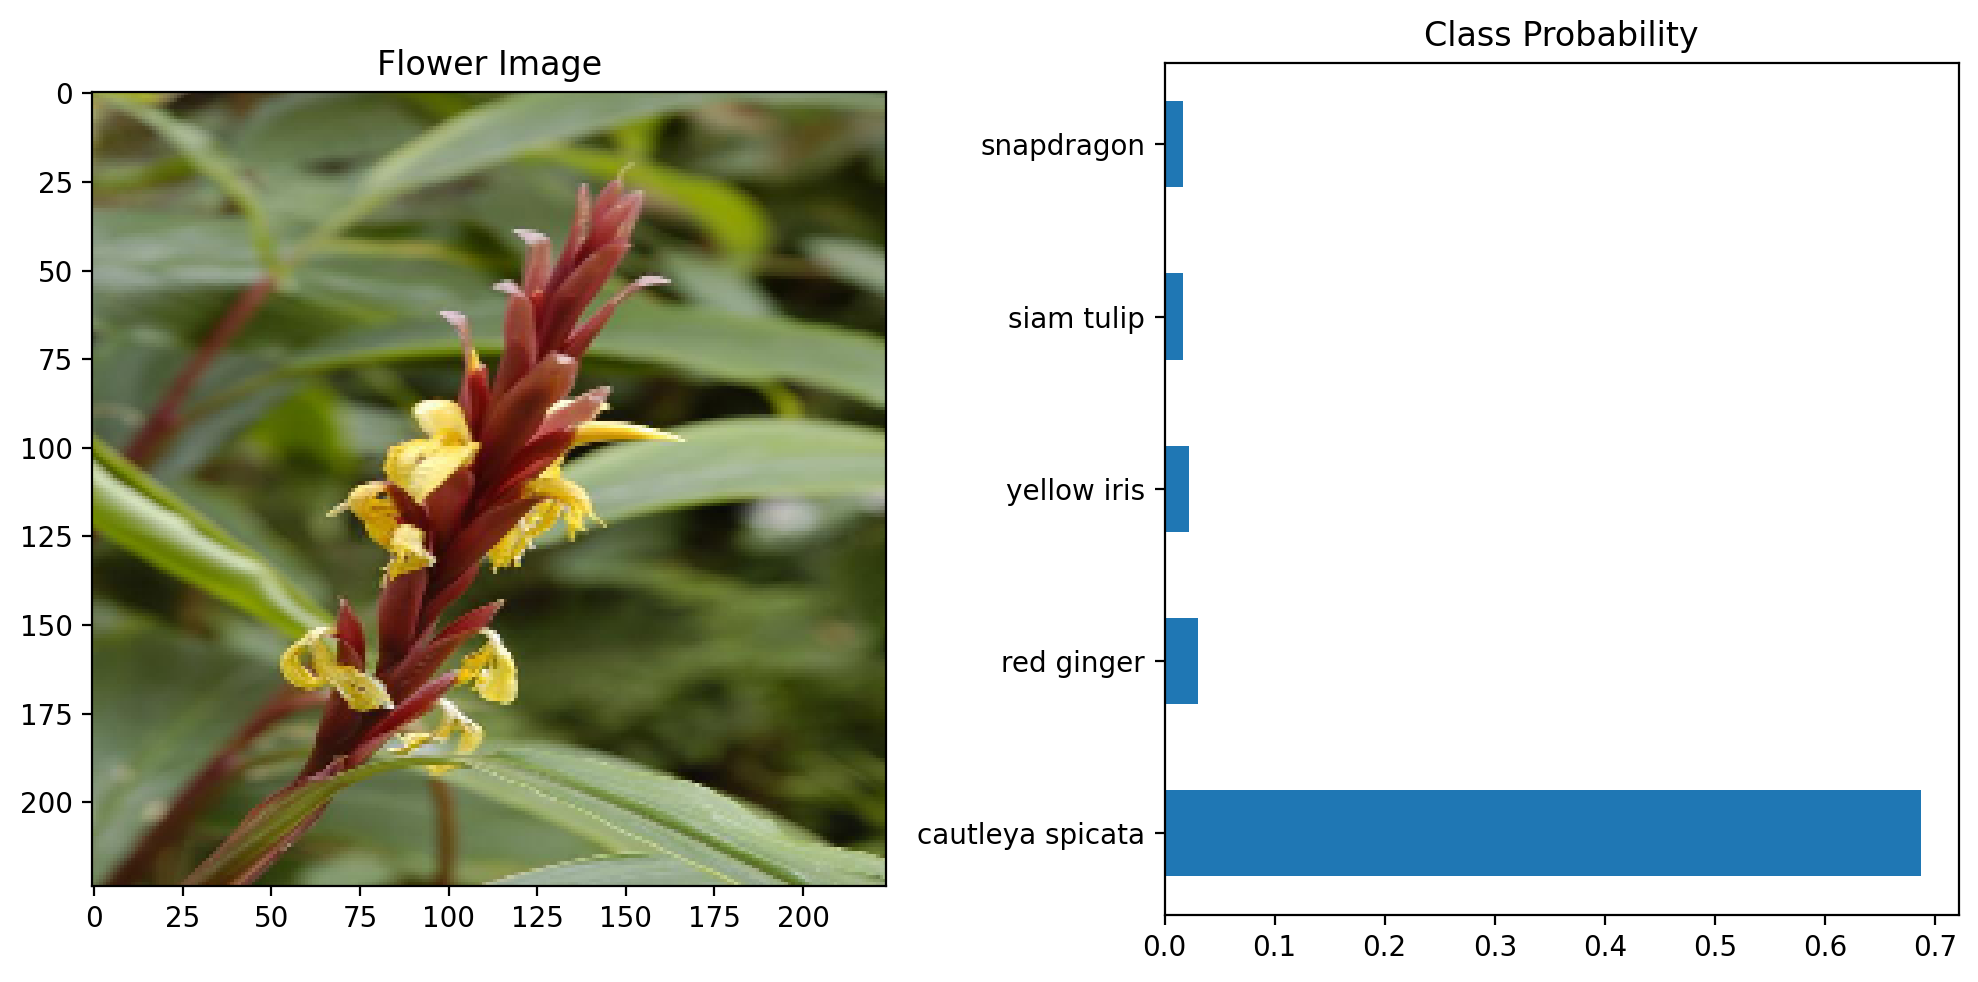

1/1 [==============================] - 0s 16ms/step


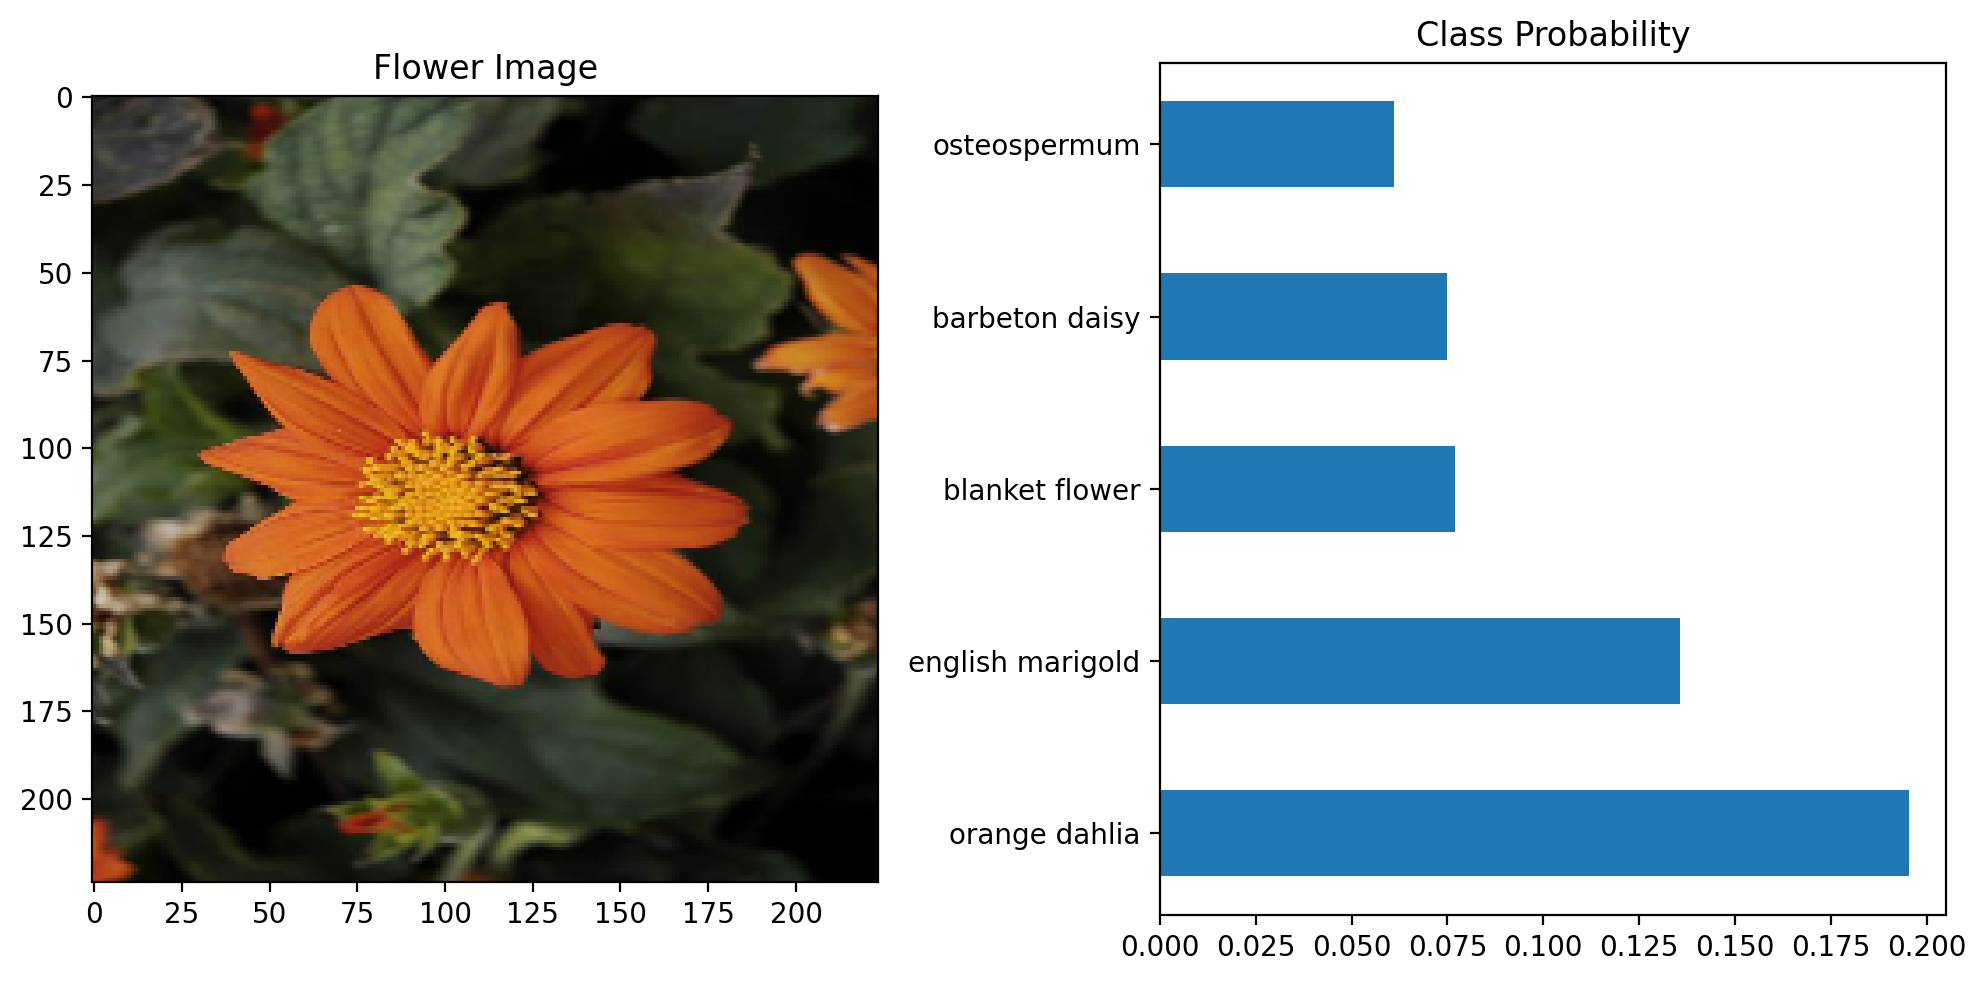

1/1 [==============================] - 0s 17ms/step


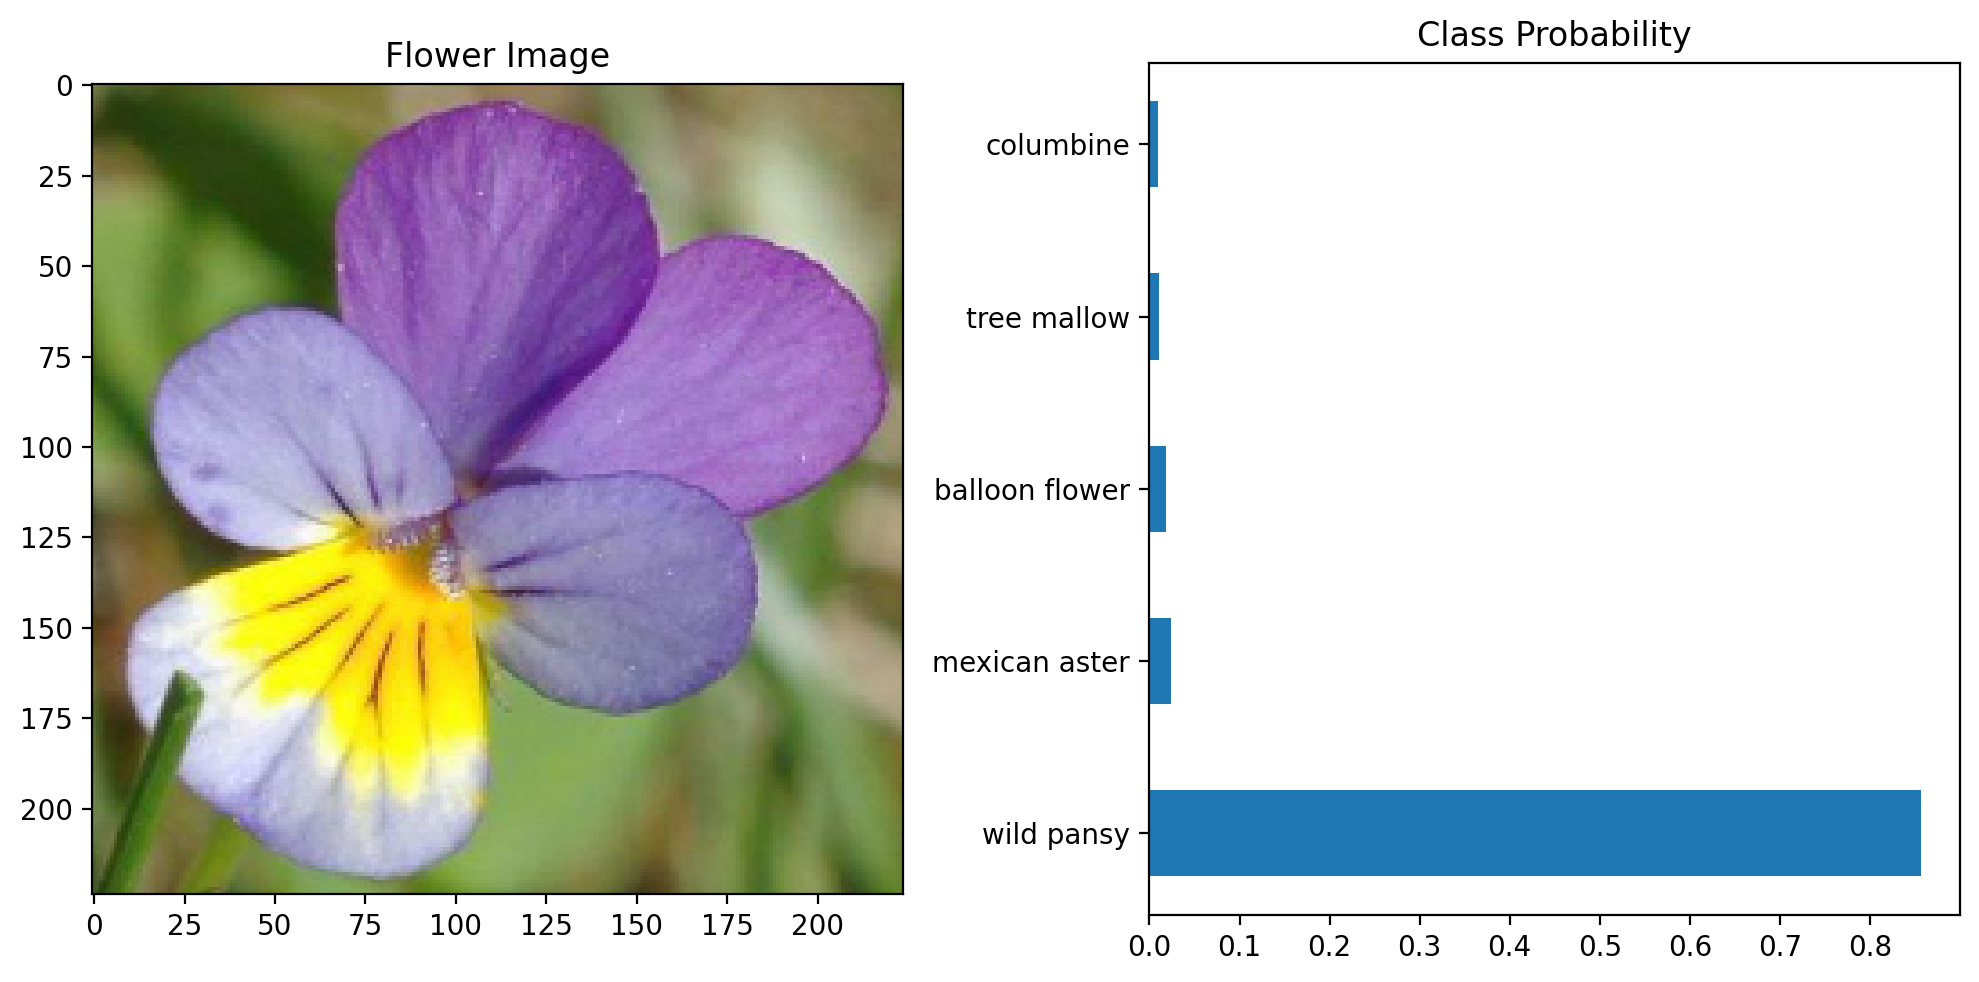

In [34]:
# TODO: Plot the input image along with the top 5 classes
def plot_flowers_with_prediction_probability (image_path, model, top_k=5):
    """
    Plots flowers with their prediction probability as a bar chart.
    """
    image = Image.open(image_path)
    image = process_image(np.asarray(image))
    prediction_prob, prediction_label = predict(image, model, top_k)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)
    ax1.imshow(image)
    ax1.set_title('Flower Image')
    ax2.barh(range(top_k), prediction_prob, height=0.5)
    ax2.set_yticks(range(top_k), [class_names.get(f'{label+1}') for label in prediction_label])
    ax2.set_title('Class Probability')
    plt.tight_layout()
    plt.show()

top_k = 5
hard_leaved_pocket_orchid = plot_flowers_with_prediction_probability('./test_images/hard-leaved_pocket_orchid.jpg', model, top_k)
cautleya_spicata = plot_flowers_with_prediction_probability('./test_images/cautleya_spicata.jpg', model, top_k)
orange_dahlia = plot_flowers_with_prediction_probability('./test_images/orange_dahlia.jpg', model, top_k)
wild_pansy = plot_flowers_with_prediction_probability('./test_images/wild_pansy.jpg', model, top_k)